<a href="https://colab.research.google.com/github/BaoNguyen151654/Database_ML_Bikeshop_Project/blob/master/BikeTier_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Overview**



Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/content/Data_for_ML.csv')
df.head()

,customer_id,total_spent,latest_purchased_brand,latest_brand_tier,most_purchased_brand,most_purchased_brand_tier,latest_brand_name,most_purchased_brand_name
0,94,34807.9392,9,high,9,high,Trek,Trek
1,94,34807.9392,9,high,9,high,Trek,Trek
2,94,34807.9392,9,high,9,high,Trek,Trek
3,94,34807.9392,9,high,9,high,Trek,Trek
4,94,34807.9392,9,high,9,high,Trek,Trek


In [3]:
df.drop(columns='customer_id', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4233 entries, 0 to 4232
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total_spent                4233 non-null   float64
 1   latest_purchased_brand     4233 non-null   int64  
 2   latest_brand_tier          4233 non-null   object 
 3   most_purchased_brand       4233 non-null   int64  
 4   most_purchased_brand_tier  4233 non-null   object 
 5   latest_brand_name          4233 non-null   object 
 6   most_purchased_brand_name  4233 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 231.6+ KB


**Conclusion:**
- I removed the `Customer ID` variable because it has no statistical
significance.
- All variables have 4,233 values, indicating there are no missing values.

- `latest_purchased_brand` and `most_purchased_brand_name` are ordinal categorical variables, so I will map them according to their order for encoding (high=3, mid=2, low=1).

- `latest_brand_tier` and `most_purchased_brand_tier` are nominal categorical variables, so I will use LabelEncoder to encode them.

- Target variable: The goal is to predict the product segment that a customer will purchase (`latest_brand_tier`). This helps the sales team adjust marketing strategies for each customer. This is a multi-class classification problem (High, Mid, Low).

- Algorithm choice: With a relatively small dataset of 4,233 samples and 5 independent variables, **Logistic Regression** is a suitable choice.

#**Feature Encoding**

Encode **nominal categorical variables**: `latest_brand_name` and `most_purchased_brand_name` (since these two variables contain the same set of values, the encoder only needs to be fitted once).

In [4]:
Encoder = LabelEncoder()
df['latest_brand_name'] = Encoder.fit_transform(df['latest_brand_name'])
df['most_purchased_brand_name'] = Encoder.transform(df['most_purchased_brand_name'])
mapping = dict(zip(Encoder.classes_, range(len(Encoder.classes_))))
print(mapping)

{'Electra': 0, 'Haro': 1, 'Heller': 2, 'Pure Cycles': 3, 'Ritchey': 4, 'Strider': 5, 'Sun Bicycles': 6, 'Surly': 7, 'Trek': 8}


Encode **ordinal categorical variables**: `latest_brand_tier` and `most_purchased_brand_tier` (mapping: high = 3, mid = 2, low = 1).

In [5]:
tier_mapping = {'high': 3, 'mid': 2, 'low': 1}
df['latest_brand_tier'] = df['latest_brand_tier'].map(tier_mapping)
df['most_purchased_brand_tier'] = df['most_purchased_brand_tier'].map(tier_mapping)

# **Oversampling Minority Class**

In [6]:
value_counts = df['latest_brand_tier'].value_counts()
value_counts

,count
latest_brand_tier,
2,2283
3,1709
1,241


Class 1 only contains **241 samples**, which is heavily underrepresented compared to the other two classes. I will use SMOTE to oversample this class to **1,200 samples**.

In [7]:
X = df.drop(columns=['latest_brand_tier'])
y = df['latest_brand_tier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy={1: 1200}, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Machine Learning with Logistic Regression**

**Logistic Regression Model Setup**

I initialize the Logistic Regression model with the following parameters:

- **penalty='elasticnet'**  
  Use Elastic Net regularization, which combines L1 (lasso) and L2 (ridge).  
  This helps with feature selection (L1) and model stability/generalization (L2).

- **l1_ratio=0.4**  
  Determines the mix between L1 and L2.  
  Here, 40% weight is given to L1 and 60% to L2, balancing sparsity and stability.

- **class_weight=weights**  
  Handles class imbalance by assigning higher weight to the minority class (class 1),  
  so the model pays more attention to underrepresented classes.

- **solver='saga'**  
  The 'saga' solver supports Elastic Net and works efficiently with large datasets  
  and sparse data.

- **max_iter=1000**  
  Sets the maximum number of iterations to ensure the optimization algorithm converges.

- **random_state=42**  
  Fixes the random seed to ensure reproducibility of results.


In [8]:
weights = {1: 3, 2: 1, 3: 1}
model = LogisticRegression(
    penalty='elasticnet',
    l1_ratio=0.4,
    class_weight=weights,
    solver='saga',
    max_iter=1000,
    random_state=42
)

score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc_ovr')
print("Mean AUC (OVR):", np.mean(score))

Mean AUC (OVR): 0.942415183628645


In [9]:
print("Mean AUC (OVR):", np.mean(score))

Mean AUC (OVR): 0.942415183628645


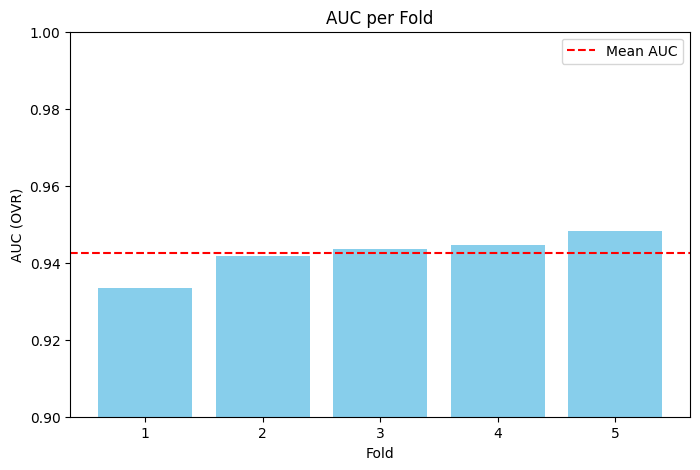

In [10]:
plt.figure(figsize=(8,5))
plt.bar(range(1, len(score)+1), score, color='skyblue')
plt.axhline(np.mean(score), color='red', linestyle='--', label='Mean AUC')
plt.xlabel('Fold')
plt.ylabel('AUC (OVR)')
plt.title('AUC per Fold')
plt.ylim(0.9,1)
plt.legend()
plt.show()

In [11]:
model.fit(X_train, y_train)
report= classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           1       0.35      0.95      0.51        65
           2       0.97      0.75      0.85       709
           3       0.86      0.93      0.89       496

    accuracy                           0.83      1270
   macro avg       0.72      0.88      0.75      1270
weighted avg       0.89      0.83      0.85      1270



After performing **5-fold cross-validation**, the model achieved a mean **AUC** of **0.94**, indicating strong overall discriminative performance.


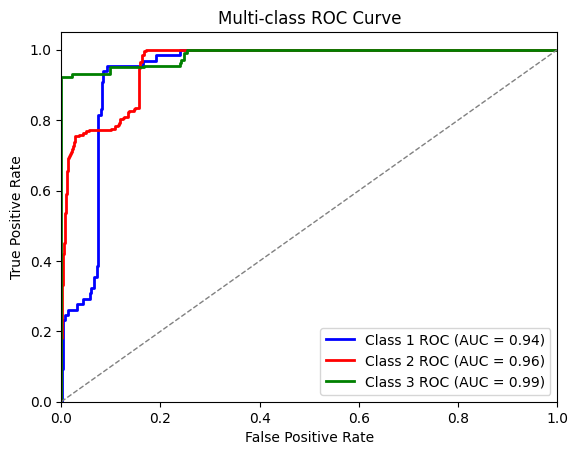

In [12]:
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_test_bin.shape[1]

y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} ROC (AUC = {1:0.2f})'.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

When evaluated on the testing set (20% of the dataset), the model achieved an AUC of **0.94** for **class 1**, **0.96** for **class 2**, and **0.99** for **class 3**.  
However, these results are only indicative, as the test set may not fully represent the entire dataset.